In [1]:
import pandas as pd

# Introduction

## COVID data

In [2]:
covid_data = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
covid_data.head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


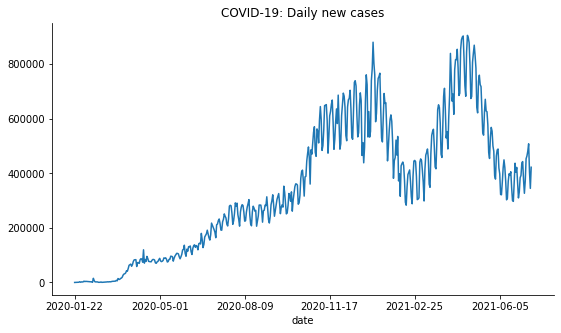

In [3]:
ax = covid_data[(covid_data['location']=='World')].plot(x='date', y='new_cases', title='COVID-19: Daily new cases', figsize=(9, 5))
ax.get_legend().remove()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig = ax.get_figure()
#fig.savefig('pictures/covid_world_daily.png')

# SARIMAX

## Moving Average

In [4]:
import math
import numpy as np

In [5]:
n = 300
sigma  = 2.0

df = pd.DataFrame({
    'Z': np.random.normal(loc=0.0, scale=sigma, size=n),
    'L': np.random.lognormal(mean=0.0, sigma=sigma, size=n),
})
df['L0'] = df['L'] - df['L'].mean() # math.exp(sigma**2/2)
df['logL'] = df['L'].apply(math.log)

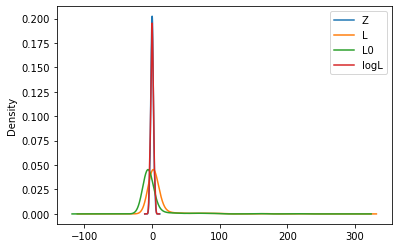

In [6]:
df.plot.kde()

In [7]:
df.describe()

,Z,L,L0,logL
count,300.000000,300.000000,3.000000e+02,300.000000
mean,0.058137,7.753581,2.321106e-15,0.048157
std,1.934409,23.393927,2.339393e+01,2.083803
min,-5.254000,0.004232,-7.749349e+00,-5.465048
25%,-1.231160,0.276144,-7.477437e+00,-1.286852
50%,-0.006405,1.024923,-6.728658e+00,0.024568
75%,1.252941,3.892411,-3.861170e+00,1.358995
max,5.888017,221.071180,2.133176e+02,5.398485


In [8]:
def pretty_plot(series, title, name=None):
    ax=series.plot(title=title, figsize=(9, 5))
    #ax.get_legend().remove()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if name is not None:
        fig = ax.get_figure()
        fig.savefig(f'pictures/{name}.png')

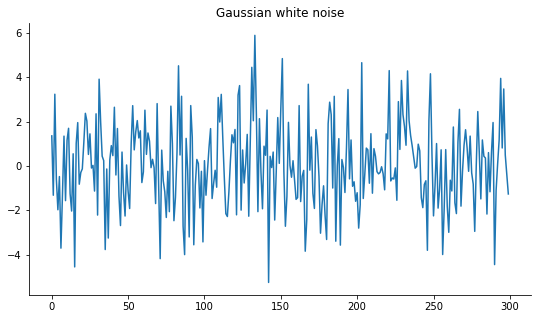

In [9]:
pretty_plot(df['Z'], title='Gaussian white noise')

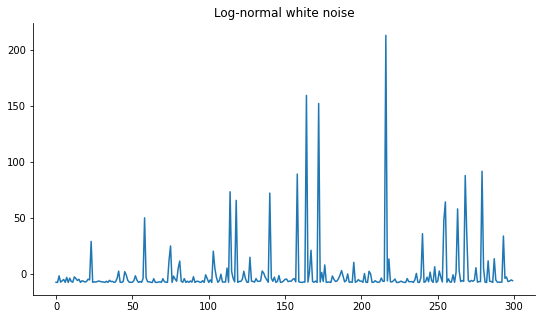

In [10]:
pretty_plot(df['L0'], title='Log-normal white noise')

In [11]:
# MA
beta_1 = 0.8
beta_2 = 0.3

df['MA(2)'] = df['Z'] + beta_1*df['Z'].shift(1) + beta_2*df['Z'].shift(2)
df['MA(1)'] = df['Z'] + beta_1*df['Z'].shift(1)

df['MA(2) L'] = df['L0'] + beta_1*df['L0'].shift(1) + beta_2*df['L0'].shift(2)
df['MA(1) L'] = df['L0'] + beta_1*df['L0'].shift(1)

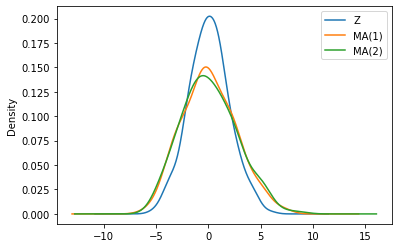

In [12]:
df[['Z', 'MA(1)', 'MA(2)']].plot.density()

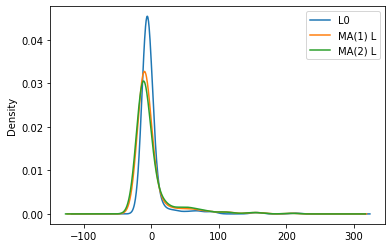

In [13]:
df[['L0', 'MA(1) L', 'MA(2) L']].plot.density()

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html

In [15]:
adfuller(df['MA(1)'].dropna(), regression='c')

(-5.902511487150751,
 2.756772573476126e-07,
 6,
 292,
 {'1%': -3.4529449243622383,
  '10%': -2.572071437887033,
  '5%': -2.871489553425686},
 1182.383552756244)

In [16]:
kpss(df['MA(1)'].dropna(), regression='c') #, nlags='auto')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


(0.0373544604198949,
 0.1,
 16,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [17]:
adfuller(df['MA(1) L'].dropna(), regression='c')

(-5.393417966854193,
 3.4967100846469905e-06,
 6,
 292,
 {'1%': -3.4529449243622383,
  '10%': -2.572071437887033,
  '5%': -2.871489553425686},
 2601.015304237465)

## Autocorrelation function

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

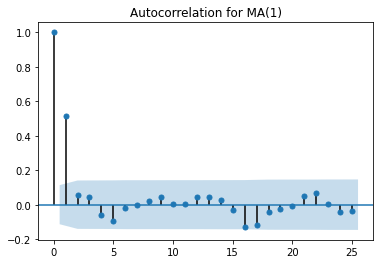

In [19]:
plot_acf(df['MA(1)'].dropna(), title='Autocorrelation for MA(1)');

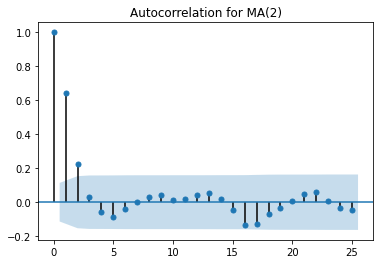

In [20]:
plot_acf(df['MA(2)'].dropna(), title='Autocorrelation for MA(2)');

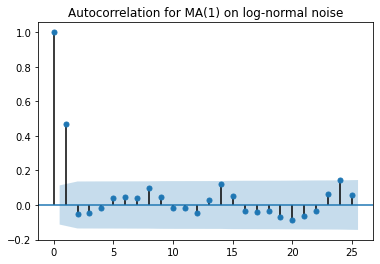

In [21]:
plot_acf(df['MA(1) L'].dropna(), title='Autocorrelation for MA(1) on log-normal noise');

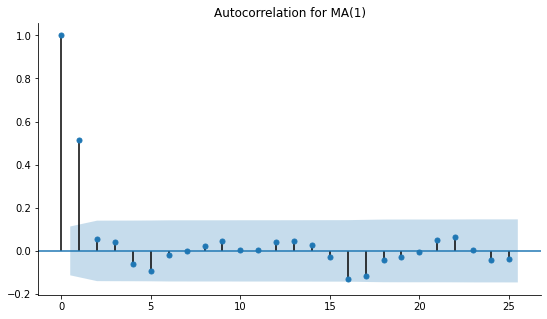

In [22]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(9,5))
plot_acf(df['MA(1)'].dropna(), ax=ax, title='Autocorrelation for MA(1)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('acf.png')

## AutoRegressive

In [23]:
#!pip install --upgrade statsmodels

In [24]:
from statsmodels.tsa.arima_process import arma_generate_sample

In [25]:
df['AR(1)'] = arma_generate_sample(ar=[1, 0.9], ma=[1], nsample=n) #, scale=sigma)

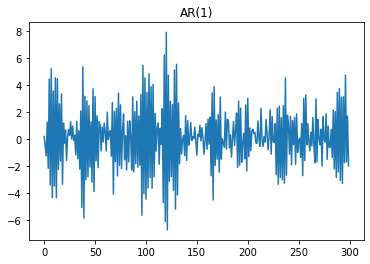

In [26]:
df['AR(1)'].plot(title='AR(1)')

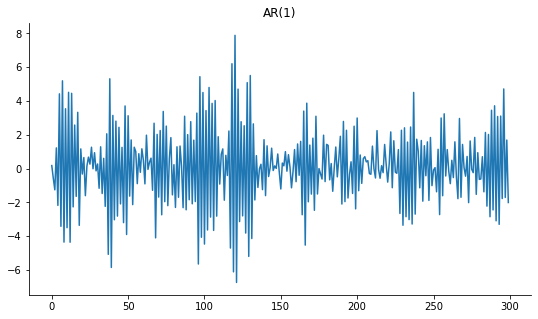

In [27]:
pretty_plot(df['AR(1)'], title='AR(1)')
plt.savefig('ar1.png')

## Partial Autocorrelation Function

In [28]:
from statsmodels.tsa.stattools import pacf
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
from statsmodels.graphics.tsaplots import plot_pacf

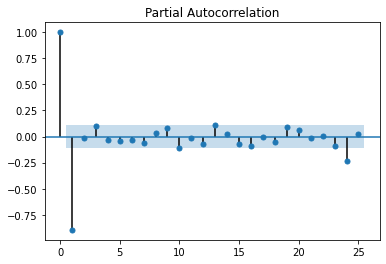

In [29]:
plot_pacf(df['AR(1)'].dropna());

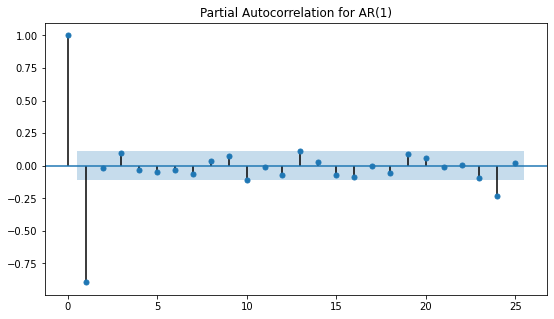

In [30]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(df['AR(1)'].dropna(), ax=ax, title='Partial Autocorrelation for AR(1)')
plt.savefig('pacf.png')

## Parameters estimation

In [31]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
model = SARIMAX(df['MA(1)'], exog=None, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1     0.864556
sigma2    3.674108
dtype: float64

In [33]:
model = SARIMAX(df['MA(1) L'], exog=None, order=(0, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1       0.775737
sigma2    546.290350
dtype: float64

In [34]:
#math.exp(sigma**2-1) * math.exp(sigma**2)

In [35]:
model = SARIMAX(df['AR(1)'], exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1    -0.888869
sigma2    1.189028
dtype: float64

In [36]:
from statsmodels.tsa.arima_process import arma_generate_sample

In [37]:
df['AR(4)'] = arma_generate_sample(ar=[1, 0.8, 0.5, 0.3, 0.1], ma=[1], nsample=n, scale=sigma)
model = SARIMAX(df['AR(4)'], exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1    -0.833014
ar.L2    -0.506746
ar.L3    -0.385819
ar.L4    -0.061217
sigma2    3.201893
dtype: float64

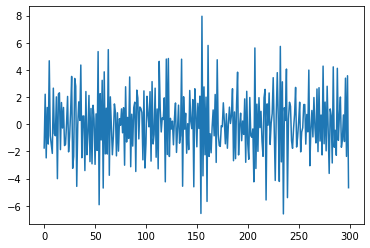

In [38]:
df['AR(4)'].plot()

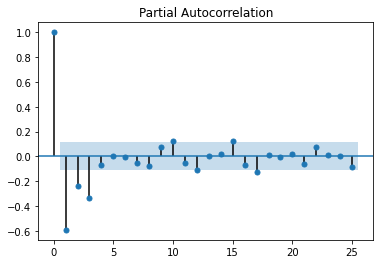

In [39]:
plot_pacf(df['AR(4)'].dropna());

In [40]:
#df = pd.DataFrame()
df['AR(1) L'] = arma_generate_sample(ar=[1, 0.8], ma=[1], nsample=n, distrvs=np.random.lognormal, scale=sigma)

In [41]:
df['AR(4) L'] = arma_generate_sample(ar=[1, 0.8, 0.5, 0.3, 0.1], ma=[1], nsample=n, distrvs=np.random.lognormal, scale=sigma)
model = SARIMAX(df['AR(4) L'], exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=[1])
model_fit = model.fit()
model_fit.params

intercept     3.669588
ar.L1        -0.785053
ar.L2        -0.508964
ar.L3        -0.292661
ar.L4        -0.097932
sigma2       20.496101
dtype: float64

In [42]:
df['AR(4) L'].std()

5.800820997257636

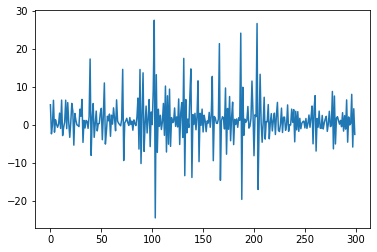

In [43]:
df['AR(4) L'].plot()

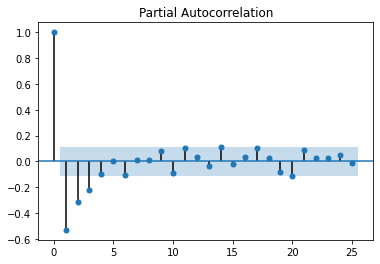

In [44]:
plot_pacf(df['AR(4) L'].dropna());

## Checking various distributions

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller

In [46]:
sigma = 2
normal = arma_generate_sample(ar=[1]+[0.8, 0.5, 0.3, 0.1], ma=[1], nsample=1000, scale=sigma)

In [47]:
#pd.Series(sigma*pareto(size=1000)).hist()

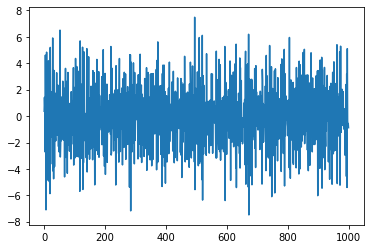

In [48]:
pd.Series(normal).plot()

In [49]:
from statsmodels.tsa.stattools import kpss

In [50]:
def estimate_params(mc, dist=np.random.standard_normal, ar_params=[0.8, 0.5, 0.3, 0.1], n=300, sigma=sigma):
    np.random.seed(mc)
    normal = arma_generate_sample(ar=[1] + ar_params, distrvs=dist, ma=[1], nsample=n, scale=sigma)
    
    p = pd.Series(abs(pacf(normal, nlags=10)))
    m = p.rolling(5, min_periods=1).mean()

    model = SARIMAX(normal, exog=None, order=(4, 0, 0), seasonal_order=(0, 0, 0, 0), trend=[1])
    model_fit = model.fit()
    return pd.DataFrame({'n': n, 'dist': dist.__name__, 'params': ar_params, 'est_params': -model_fit.params[1:-1], 
                         'coeff': model_fit.params[1], 'sigma2':sigma*sigma, 'est_sigma2': model_fit.params[-1], 
                         'est_p': m[m < (m.shift(1)*0.7)].index.min() - 1, 
                         'pacf': p[1:5],
                         'stationary_ct': adfuller(normal, regression='ct')[1] < 0.05,
                         'stationary_ct_kpss': kpss(normal, regression='ct', nlags="auto")[1] > 0.05,
                         'stationary_c': adfuller(normal, regression='c')[1] < 0.05
                        })

In [51]:
estimate_params(1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1911: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


,n,dist,params,est_params,coeff,sigma2,est_sigma2,est_p,pacf,stationary_ct,stationary_ct_kpss,stationary_c
1,300,standard_normal,0.8,0.857079,-0.857079,4,3.527773,4,0.585105,True,True,True
2,300,standard_normal,0.5,0.544178,-0.857079,4,3.527773,4,0.281198,True,True,True
3,300,standard_normal,0.3,0.375592,-0.857079,4,3.527773,4,0.294503,True,True,True
4,300,standard_normal,0.1,0.105446,-0.857079,4,3.527773,4,0.111171,True,True,True


In [52]:
def pareto(size):
    return np.random.pareto(10, size)

In [53]:
dist_vec = [np.random.standard_normal, np.random.exponential, np.random.poisson, np.random.lognormal, pareto]
n_vec = [24, 48, 72, 100, 200, 300, 500, 1000]
mc_vec = range(100)

In [54]:
# # TODO check stationarity - wrongly assumed they are not statinary
# # guessing parameter on pacf
# res_array = []
# for dist in dist_vec:
#     print(dist)
#     for n in n_vec:
#         for mc in mc_vec:
#             res_one = estimate_params(mc=mc, dist=dist, n=n)
#             res_one['mc'] = mc
#             res_array.append(res_one)

In [56]:
# res = pd.concat(res_array)

## AutoRegressive Moving Average

In [57]:
df['ARMA(1,1)'] = df['AR(1)'] + df['MA(1)']  #arma_generate_sample(ar=[1, -0.9], ma=[1, 0.2], nsample=n, scale=sigma) 
#df['ARMA(1,1) L'] = df['AR(1) L'] + df['MA(1) L']

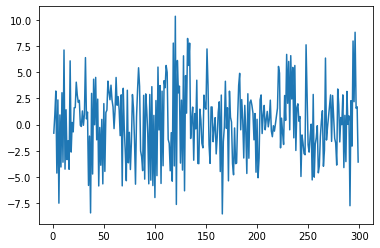

In [58]:
df['ARMA(1,1)'].plot()

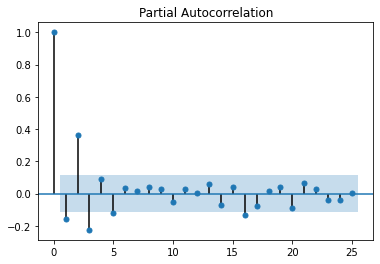

In [59]:
plot_pacf(df['ARMA(1,1)'].dropna());

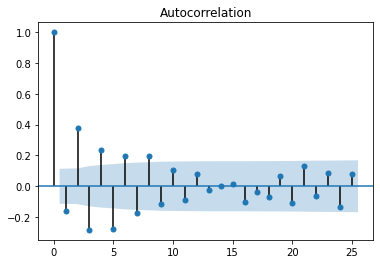

In [60]:
plot_acf(df['ARMA(1,1)'].dropna());

In [61]:
model = SARIMAX(df['ARMA(1,1)'], exog=None, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0), trend=None)
model_fit = model.fit()
model_fit.params

ar.L1     -0.925335
ma.L1      0.760657
sigma2    10.343987
dtype: float64

## AutoRegressive Integrated Moving Average

In [62]:
import matplotlib.pyplot as plt

In [63]:
df['t'] = range(df.shape[0])

In [64]:
df['ARIMA(1,1,1)'] = df['ARMA(1,1)'] + df['t']/5

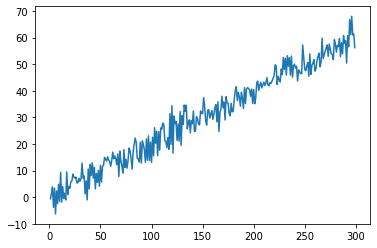

In [65]:
df['ARIMA(1,1,1)'].plot()

In [66]:
adfuller(df['ARIMA(1,1,1)'].dropna(), regression='ct')

(-7.95922483772557,
 8.87726653969244e-11,
 4,
 294,
 {'1%': -3.9898970270434053,
  '10%': -3.1358908478232332,
  '5%': -3.4255296586298916},
 1453.5844774952284)

In [67]:
kpss(df['ARIMA(1,1,1)'].dropna(), regression='c', nlags='auto')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(2.8130600712760687,
 0.01,
 10,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

In [68]:
adfuller(df['ARIMA(1,1,1)'].diff(1).dropna(), regression='c')

(-8.596587578390755,
 7.05062143761026e-14,
 11,
 286,
 {'1%': -3.4534232986669546,
  '10%': -2.5721833625116144,
  '5%': -2.8716994185534745},
 1475.1943819249695)

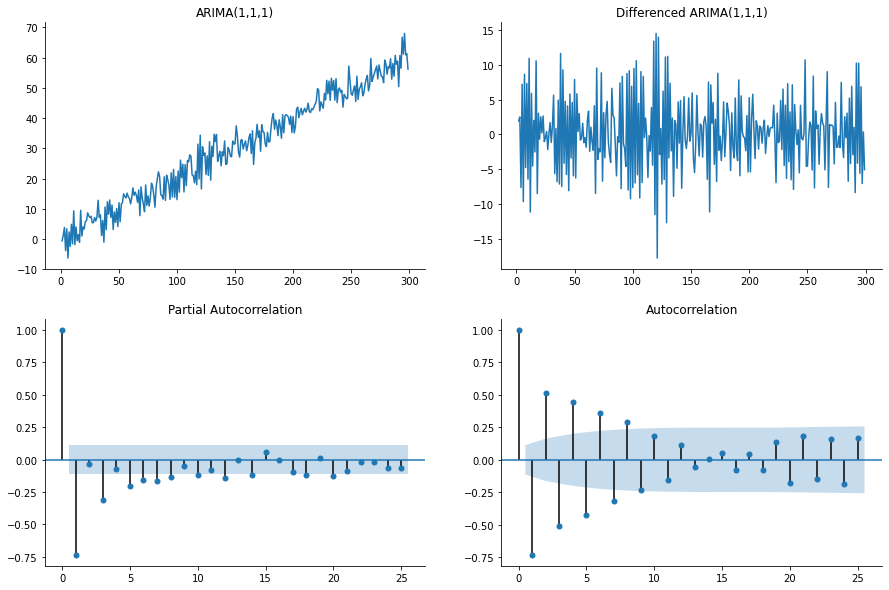

In [69]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['ARIMA(1,1,1)'].plot(title='ARIMA(1,1,1)', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['ARIMA(1,1,1)'].diff(1).plot(ax=ax2, title='Differenced ARIMA(1,1,1)')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plot_pacf(df['ARIMA(1,1,1)'].diff(1).dropna(), title='Partial Autocorrelation', ax=ax3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['ARIMA(1,1,1)'].diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/arima.png')

In [70]:
model = SARIMAX(df['ARIMA(1,1,1)'], exog=None, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), trend=[1])
model_fit = model.fit()
model_fit.params

intercept     0.232249
ar.L1        -0.155966
ma.L1        -0.998768
sigma2       11.982408
dtype: float64

## Seasonal AutoRegressive Moving Average

In [71]:
df['cos'] = df['t'].apply(lambda x: 10*math.cos(x / 12 * 2 * math.pi) )
df['SARIMA (0,1,1) (0,1,0)12'] = df['cos'] + df['MA(1)'] + df['t']*df['t']/1000
df['SARIMA (0,1,1) (0,1,0)12 L'] = 5*df['cos'] + df['AR(1) L'] + df['t']*df['t']/100

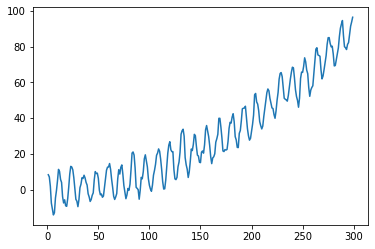

In [72]:
df['SARIMA (0,1,1) (0,1,0)12'].plot()

In [73]:
#df['SARIMA (0,1,1) (0,1,0)12 L'].plot()

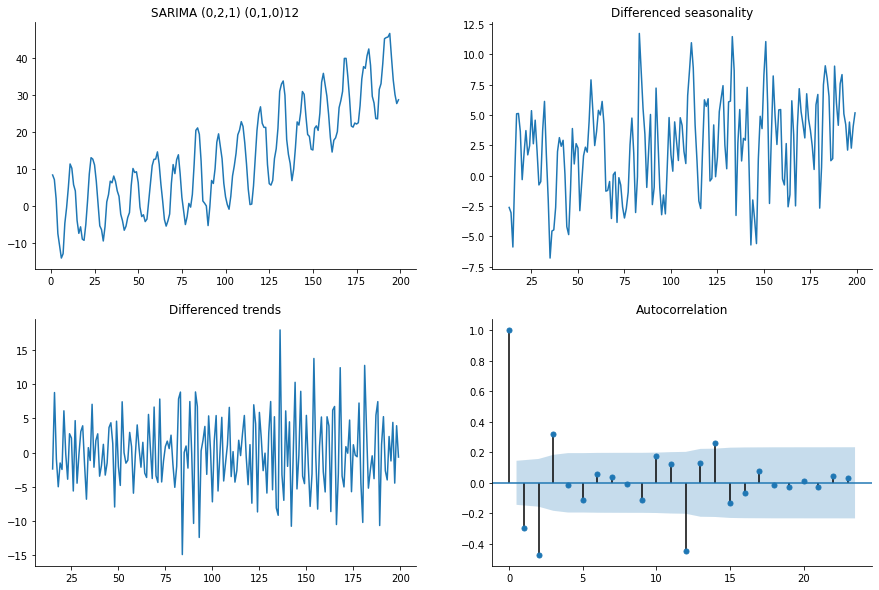

In [74]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].plot(title='SARIMA (0,2,1) (0,1,0)12', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).plot(ax=ax2, title='Differenced seasonality')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).diff(1).diff(1).plot(ax=ax3, title='Differenced trends')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['SARIMA (0,1,1) (0,1,0)12'].iloc[:200].diff(12).diff(1).diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/sarima.png')

In [75]:
model = SARIMAX(df['SARIMA (0,1,1) (0,1,0)12'], exog=None, order=(0,2,1), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params

ma.L1     -0.999751
sigma2    12.338498
dtype: float64

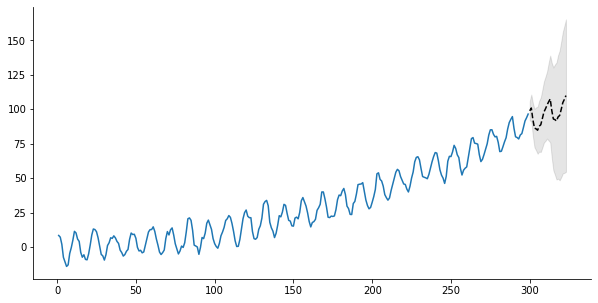

In [76]:
fcst = model_fit.get_forecast(2*12).summary_frame()

fig, ax = plt.subplots(figsize=(10, 5))

df['SARIMA (0,1,1) (0,1,0)12'].plot(ax=ax)

fcst['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], color='k', alpha=0.1);

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig = ax.get_figure()
fig.savefig(f'prediction_intervals.png')

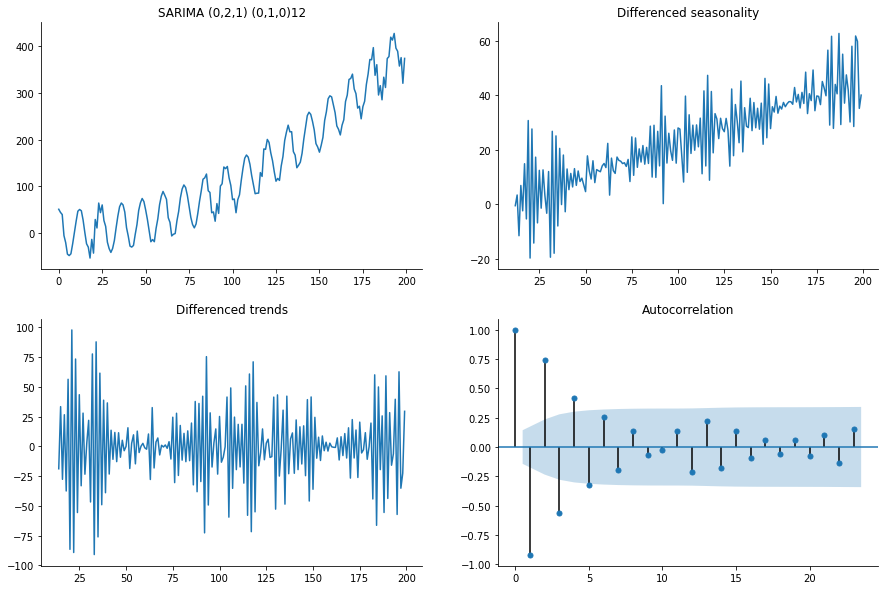

In [77]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].plot(title='SARIMA (0,2,1) (0,1,0)12', ax=ax1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).plot(ax=ax2, title='Differenced seasonality')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).diff(1).diff(1).plot(ax=ax3, title='Differenced trends')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

plot_acf(df['SARIMA (0,1,1) (0,1,0)12 L'].iloc[:200].diff(12).diff(1).diff(1).dropna(), title='Autocorrelation', ax=ax4)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

#fig = ax.get_figure()
#fig.savefig('pictures/sarima.png')

In [78]:
model = SARIMAX(df['SARIMA (0,1,1) (0,1,0)12 L'], exog=None, order=(1,2,0), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params
#model_fit.get_prediction(start=dataset.index[0], end=dataset.index[10]).summary_frame()

ar.L1      -0.893539
sigma2    246.029100
dtype: float64

In [79]:
#!pip install pmdarima

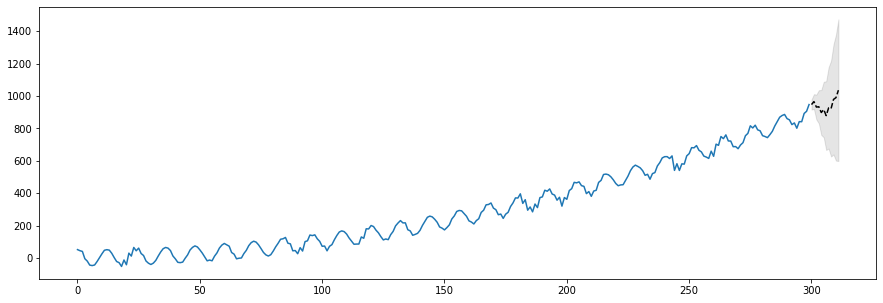

In [80]:
fcst = model_fit.get_forecast(12).summary_frame()

fig, ax = plt.subplots(figsize=(15, 5))

df['SARIMA (0,1,1) (0,1,0)12 L'].plot(ax=ax)

fcst['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcst.index, fcst['mean_ci_lower'], fcst['mean_ci_upper'], color='k', alpha=0.1);

## Fitting best model

In [81]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     |████████████████████████████████| 1.5MB 28.3MB/s 


In [82]:
model = auto_arima(df['MA(1)'].dropna())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -619.498
Date:                Tue, 13 Jul 2021   AIC                           1242.996
Time:                        09:15:28   BIC                           1250.397
Sample:                             0   HQIC                          1245.958
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8646      0.030     28.560      0.000       0.805       0.924
sigma2         3.6741      0.298     12.349      0.000       3.091       4.257
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.64   Prob(JB):                         0.85
Heteroskedasticity (H):               0.94   Skew:                             0.08
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
model = auto_arima(df['AR(1)'].dropna())
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -448.549
Date:                Tue, 13 Jul 2021   AIC                            903.098
Time:                        09:15:29   BIC                            914.210
Sample:                             0   HQIC                           907.545
                                - 300                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1747      0.062      2.801      0.005       0.052       0.297
ar.L1         -0.8918      0.025    -35.580      0.000      -0.941      -0.843
sigma2         1.1585      0.096     12.056      0.000       0.970       1.347
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.73   Prob(JB):                         0.71
Heteroskedasticity (H):               0.86   Skew:                            -0.12
Prob(H) (two-sided):                  0.46   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

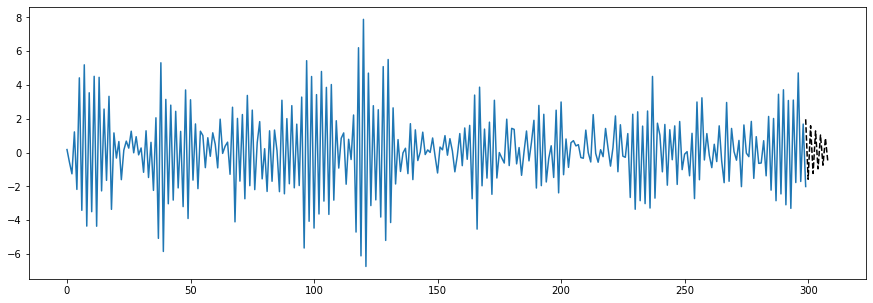

In [84]:
fig, ax = plt.subplots(figsize=(15, 5))

df['AR(1)'].plot(ax=ax)

pd.Series(model.predict(), index=range(df.index.max(), df.index.max()+ len(model.predict()) )).plot(ax=ax, style='k--')

# COVID dat

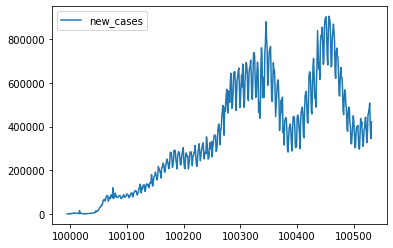

In [85]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")
#covid.head(2)

target = 'new_cases'
h = 14

dataset = covid[(covid['location']=='World')].copy()[[target, 'date']]
dataset[[target]].plot()

In [86]:
model = SARIMAX(dataset[target], exog=None, order=(1,2,0), seasonal_order=(0, 1, 0, 12), trend=None)
model_fit = model.fit()
model_fit.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ar.L1    -2.274833e-01
sigma2    1.005850e+10
dtype: float64

In [87]:
from sklearn.base import BaseEstimator, RegressorMixin


class SARIMARegressor(BaseEstimator, RegressorMixin):
    # https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

    def __init__(self, order=(1,2,0), seasonal_order=(0, 1, 0, 12)):
        self.order = order
        self.seasonal_order = seasonal_order

        self.model = None
        self.predictions= None
        self.feature_importances_ = [0]

    def fit(self, X, y):
        model = SARIMAX(y, exog=None, order=self.order, seasonal_order=self.seasonal_order, trend=None)
        model_fit = model.fit()
        self.model = model_fit
        return self

    def predict(self, X):
        X = np.ndarray.flatten(X)
        predictions = self.model.get_prediction(start=min(X), end=max(X)).summary_frame()
        self.predictions = predictions[['mean_ci_lower', 'mean_ci_upper']].rename(columns={'mean_ci_lower': 'pi_lower', 'mean_ci_upper': 'pi_upper'})
        return predictions['mean'].values

    def get_params(self, deep=True):
        return {"order": self.order, 'seasonal_order': self.seasonal_order}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [88]:
sr = SARIMARegressor()
sr.fit(dataset[target], dataset[target])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SARIMARegressor(order=(1, 2, 0), seasonal_order=(0, 1, 0, 12))

In [89]:
!pip install sklearn-ts==0.0.5

In [90]:
from sklearn_ts.validator import check_model

{'regressor__order': (4, 1, 4), 'regressor__seasonal_order': (0, 1, 1, 7)}

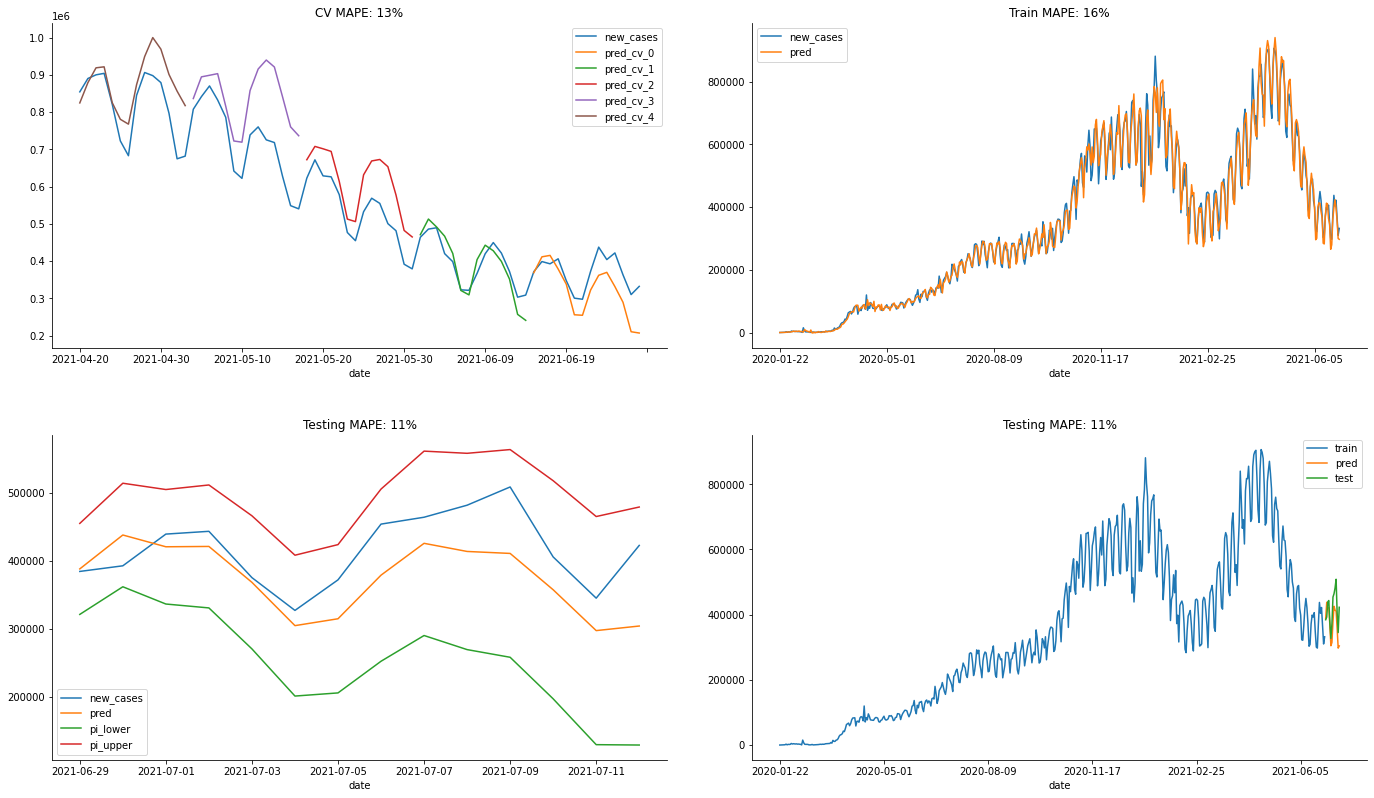

In [108]:
import warnings
warnings.filterwarnings('ignore')

params = {'order': [(4, 1, 4)], 'seasonal_order': [(0, 1, 1, 7)]}
regressor = SARIMARegressor()

dataset.index = dataset['date']

results = check_model(regressor, params, dataset)
results['best_params']

## Sktime

In [93]:
!pip install sktime==0.6.1
from sktime.forecasting.arima import AutoARIMA

     |████████████████████████████████| 5.7MB 27.3MB/s 
     |████████████████████████████████| 22.3MB 53.7MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [94]:
forecaster = AutoARIMA(suppress_warnings=True,sp=12)
forecaster.fit(df['SARIMA (0,1,1) (0,1,0)12'].dropna())

AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
          information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=None, scoring='mse', scoring_args=None, seasonal=True,
          seasonal_test='ocsb', seasonal_test_args=None, sp=12, start_P=1,
          start_Q=1, start_p=2, start_params=None, ...)

In [95]:
forecaster.get_fitted_params()

{'ar.S.L12': 0.9966903185871103,
 'ma.L1': 0.03699631236198338,
 'ma.L2': -0.7436292814362292,
 'ma.S.L12': -0.8421374721567539,
 'sigma2': 4.506283698141853}

In [101]:
?AutoARIMA

In [97]:
y_pred = forecaster.predict(fh=list(range(1, 4*12 +1)), return_pred_int=True, alpha=0.05)
y_pred[1]['mean'] = y_pred[0]
y_pred = y_pred[1]
y_pred.head()

,lower,upper,mean
300,94.110570,102.432065,98.271318
301,92.633355,104.621394,98.627374
302,89.085721,101.319801,95.202761
303,85.138933,97.614202,91.376568
304,80.295287,93.007170,86.651229


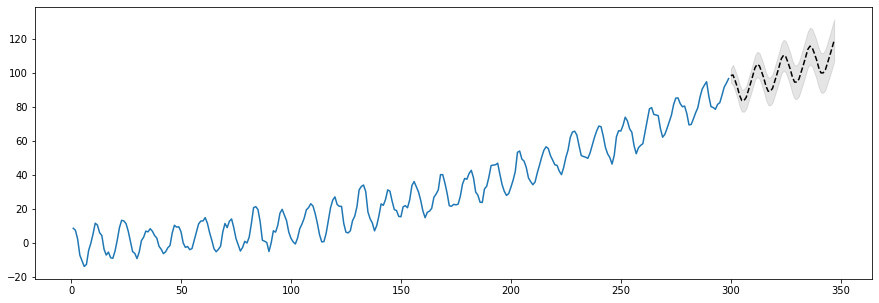

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))

df['SARIMA (0,1,1) (0,1,0)12'].plot(ax=ax)

y_pred['mean'].plot(ax=ax, style='k--')
ax.fill_between(y_pred.index, y_pred['lower'], y_pred['upper'], color='k', alpha=0.1)

In [100]:
forecaster = AutoARIMA(suppress_warnings=True,sp=12)
dataset.index = pd.to_datetime(dataset['date'])
forecaster.fit(dataset['new_cases'])

AutoARIMA(D=None, alpha=0.05, d=None, error_action='warn',
          information_criterion='aic', max_D=1, max_P=2, max_Q=2, max_d=2,
          max_order=5, max_p=5, max_q=5, maxiter=50, method='lbfgs', n_fits=10,
          n_jobs=1, offset_test_args=None, out_of_sample_size=0, random=False,
          random_state=None, scoring='mse', scoring_args=None, seasonal=True,
          seasonal_test='ocsb', seasonal_test_args=None, sp=12, start_P=1,
          start_Q=1, start_p=2, start_params=None, ...)

In [102]:
forecaster.get_fitted_params()

{'ar.L1': 0.3236783619889991,
 'ar.L2': -1.0078287219849145,
 'ar.L3': 0.05272184133846358,
 'ar.L4': -0.5671222705065625,
 'ar.L5': -0.46603918244748677,
 'ma.L1': -0.7417373345065308,
 'ma.L2': 1.101460499740988,
 'ma.L3': -0.5051584417131683,
 'ma.L4': 0.5781468254221949,
 'ma.S.L12': 0.10794904608826383,
 'sigma2': 1067379459.9240326}